## Student Number : 19200109

Libraries required for the tasks in the assignment

In [271]:
import requests
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report
import numpy as np

## Task 1: Collection of Data and Storage

Storing the url from which categories are selected and making call to the webpage by using requests

In [272]:
url="http://mlg.ucd.ie/modules/yalp/"
rawHtml = requests.get(url)

verifying whether the call made to the webpage is successfull and if we have received the contents of the webpage for which the request is made

In [273]:
print(rawHtml.status_code)
#print(rawHtml.content)

200


Parsing the content of the webpage using the beautifulsoup parser and selecting the required data from the parsed webpage by accessing the different elements of the webpage

In [274]:
htmlParsed = BeautifulSoup(rawHtml.content,"html.parser")
#print(htmlParsed)
# selecting all the elements in the webpage whose class is category
mainPageCategories = htmlParsed.find_all(class_="category")
#print(mainPageCategories)

#### Categories i have chosen are as below
1) Category: Automotive<br>
2) Category: Gym<br>
3) Category: Hotels

In [275]:
myCategories = ["Automotive","Gym","Hotels"]

Below is the code used to scrape through the webpages and select the reviews and their corresponding ratings and storing them 

In [276]:
# allRecords is the variable used to store the webscraped data
allRecords=[]
#we now iterate through all the categories which we got from the above step
for categoryDiv in mainPageCategories:
    # for each category element we look for the content within the tag <a> and split that content by ": "
    nameOfCategories = categoryDiv.find("a").get_text().split(": ")
    # print(nameOfCategories)
    # we now iterate through categories we have got after splitting the content between <a> tag
    for categoryName in nameOfCategories:
        # if the category name is same as the category in my selected list of categories then i continue further webscraping      
        if categoryName in myCategories:
            #print(categoryName)
            # finding the text between <a> tag which gives me the url for the page which contains all businesses             
            businessPageUrl = url+categoryDiv.find("a").get('href')
            #print(businessPageUrl)
            # Making the webrequest to fetch contents from page with all businesses             
            businessPageRawHtml = requests.get(businessPageUrl)
            # Parsing the content of the webpage using the beautifulsoup parser and selecting the required data
            # from the parsed webpage by accessing the different elements of the webpage             
            businessPageRawHtmlParsed = BeautifulSoup(businessPageRawHtml.content,"html.parser")
            #print(businessPageRawHtmlParsed)
            # Fetching the list of businesses which is found within h5 tag
            listOfBusinesses = businessPageRawHtmlParsed.find_all('h5')
            # Iterating through each of the businesses             
            for eachBusiness in listOfBusinesses:
                #print(business)
                # finding the text between <a> tag which gives me the url for the page which contains all reviews  
                reviewPageUrl = url+eachBusiness.find('a').get('href')
                #print(reviewPageUrl)
                # Making the webrequest to fetch contents from page with all reviews 
                reviewPageRawHtml = requests.get(reviewPageUrl)
                # Parsing the content of the webpage using the beautifulsoup parser and selecting the required data
                # from the parsed webpage by accessing the different elements of the webpage
                reviewPageRawHtmlParsed = BeautifulSoup(reviewPageRawHtml.content,"html.parser")
                #print(reviewPageRawHtmlParsed)
                # Fetching the list of reviews whose class is review
                listOfReviews = reviewPageRawHtmlParsed.find_all(class_='review')
                 # Iterating through each of the reviews
                for eachReview in listOfReviews:
                    #print(eachReview)
                    # Now we fetch the review text whose class is review-text
                    reviewText = eachReview.find(class_='review-text').get_text()
                    # Then we fetch the review rating which is present with img tag and its value with alt tag
                    #  then we split the content for example 1-star with - to get just the number 1                    
                    reviewRating=int(eachReview.find('img').get('alt').split('-')[0])
                    dataPerRow = []
                    #  Forming single row data by appending category name                    
                    dataPerRow.append(categoryName)
                    #  Forming single row data by appending review text 
                    dataPerRow.append(reviewText)
                    #  Forming single row data by appending review rating 
                    dataPerRow.append(reviewRating)
                    #  Forming single row data by appending feedbacktype if review is <=3 then negative else positive
                    if reviewRating<=3:
                        dataPerRow.append("Negative")
                    else:
                        dataPerRow.append("Positive")
                    #print(dataPerRow)
                    # storing one full record                      
                    allRecords.append(dataPerRow)

we now form the data frame with all the records and specify the column names 'Category','Review','Rating','FeedBackType' repectively and store the entire data in the file rawDataset.csv

In [277]:
#print(dataPerRow)
# creating the dataframe and also assigning the column names
dataFrame = pd.DataFrame(allRecords,columns=['Category','Review','Rating','FeedBackType'])
#saving all records to csv file
dataFrame.to_csv("rawDataset.csv",index=False)

Creating the sepearte dataframes for each category chosen from the data frame which contains all data

In [278]:
categoryAutomotive = dataframe[dataframe.Category == 'Automotive']
categoryGym = dataframe[dataframe.Category == 'Gym']
categoryHotels = dataframe[dataframe.Category == 'Hotels']

## Task 2: Pre-Processing, Building Model and Testing

Forming the dataframe which is used for predicting and modelling and storing just the reviews and feedbacktype into csv files for each Category(as mentioned in the document).

In [279]:
category1=categoryAutomotive[['Review','FeedBackType']]
category1.to_csv("categoryAutomotive.csv",index=False)
category2=categoryGym[['Review','FeedBackType']]
category2.to_csv("categoryGym.csv",index=False)
category3=categoryHotels[['Review','FeedBackType']]
category3.to_csv("categoryHotels.csv",index=False)
#print(category1)
#print(category2)
#print(category3)

Storing the reviews in one variable and feedbacktype in another variable so its easy while predicitng and modelling for each Category

In [280]:
reviewCategory1 = category1.Review
targetTypeCategory1 = category1.FeedBackType
reviewCategory2 = category2.Review
targetTypeCategory2 = category2.FeedBackType
reviewCategory3 = category3.Review
targetTypeCategory3 = category3.FeedBackType

### Classication model using Naive Bayes classifier for Category 1- Automative

#### PreProcessing: Category1-Automotive

I use the TfidfVectorizer to convert the text documents into numerical format, to form stems, to remove stop words and to generate the Category1-Automative document matrix.<br>
Min_def states that if a token appears in the minimum number of documents defined then that token must be considered.<br> The next step is to split the Category1-Automotive data into the training set and test set. I chose 70% of the data in Category1-Automotive as the training set, and 30% of the total data in Category1-Automotive as the test set

In [281]:
vectorizerCategory1 = TfidfVectorizer(stop_words="english",min_df=3,strip_accents='unicode')
category1X = vectorizerCategory1.fit_transform(reviewCategory1)
category1_train_x, category1_test_x, category1_train_y, category1_test_y = train_test_split(category1X, targetTypeCategory1, test_size=0.3)

#### Creating Model: Category1-Automotive
Creating the Naive Bayes model and Category1-Automotive training data is fitted

In [282]:
nbCategory1 = GaussianNB()
nbCategory1.fit(category1_train_x.toarray(), category1_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Predicting: Category1-Automotive
Model generated in the above step is used for predicting test set of Category1-Automotive

In [283]:
category1_y_perdiction = nbCategory1.predict(category1_test_x.toarray())

#### Testing: Category1-Automotive
From the matrix below we see that the number of records for Negative and Positive feedbacktype are not equal. Information is imbalanced, in other words. Assessment needs another approach

In [284]:
category1.groupby(['FeedBackType']).agg(pd.Series.count)

,Review
FeedBackType,
Negative,788
Positive,1212


The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [285]:
print(confusion_matrix(category1_test_y, category1_y_perdiction,labels=['Negative','Positive']))

[[180  62]
 [ 98 260]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information for Category1-Automotive<br> Accuracy, Recall, F1 score and Support are calculated below.

In [286]:
print(classification_report(category1_test_y, category1_y_perdiction, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.65      0.74      0.69       242
    Positive       0.81      0.73      0.76       358

    accuracy                           0.73       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.74      0.73      0.74       600



The F1 score could be used to compare results for each class, as previously stated, with the imbalanced data. Below are the F1 scores evaluated for Category1-Automotive data for Negative and Positive Class. Within the later portion, this data is expressed graphically by F1 scores with other categories.

In [287]:
category1f1_pos = f1_score(category1_test_y, category1_y_perdiction, pos_label='Positive')
category1f1_neg = f1_score(category1_test_y, category1_y_perdiction, pos_label='Negative')
print("F1 score for POSITIVE review = %.2f" % category3f1_pos )
print("F1 score for NEGATIVE review = %.2f" % category3f1_neg )

F1 score for POSITIVE review = 0.76
F1 score for NEGATIVE review = 0.68


#### Cross validation used for the Prediction and Evaluation<br>
I used cross validation because the data is imbalanced, the model stacking approach is used for better evaluation, we don't have to worry about changing the parameters because it takes care of it on its own, uses all the data available, gives preference to dependent and grouped data and has a better metric system.

In [288]:
accuracies = cross_val_score(nb, category1X.toarray(), targetTypeCategory1, cv=5, scoring="accuracy")
labels = [ "Fold %d" % i for i in range(1,len(accuracies)+1) ]
accuracy_series = pd.Series(accuracies, index = labels)
print("Mean accuracy: %.4f" % accuracy_series.mean() )

Mean accuracy: 0.6820


### Classication model using Naive Bayes classifier for category 2-Gym

#### PreProcessing: Category2-Gym
I use the TfidfVectorizer to convert the text documents into numerical format, to form stems, to remove stop words and to generate the Category2-Gym document matrix.
Min def states that if a token appears in the minimum number of documents defined then that token must be considered.<br > The next step is to split the Category2-Gym data into the training set and test set. I chose 70% of the data in Category2-Gym as the training set, and 30% of the total data in Category2-Gym as the test set

In [289]:
vectorizerCategory2 = TfidfVectorizer(stop_words="english",min_df=3,strip_accents='unicode')
category2X = vectorizerCategory2.fit_transform(reviewCategory2)
category2_train_x, category2_test_x, category2_train_y, category2_test_y = train_test_split(category2X, targetTypeCategory2, test_size=0.3)

#### Creating Model: Category2-Gym
Creating the Naive Bayes model and Category2-Gym training data is fitted

In [290]:
nbCategory2 = GaussianNB()
nbCategory2.fit(category2_train_x.toarray(), category2_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Predicting: Category2-Gym
Model generated in the above step is used for predicting test set of Category2-Gym

In [291]:
category2_y_perdiction = nbCategory2.predict(category2_test_x.toarray())

#### Testing: Category2-Gym
From the matrix below we see that the number of records for Negative and Positive feedbacktype are not equal. Information is imbalanced, in other words. Assessment needs another approach

In [292]:
category2.groupby(['FeedBackType']).agg(pd.Series.count)

,Review
FeedBackType,
Negative,701
Positive,1299


The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [293]:
print(confusion_matrix(category2_test_y, category2_y_perdiction,labels=['Negative','Positive']))

[[181  45]
 [ 85 289]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information for Category2-Gym<br> Accuracy, Recall, F1 score and Support are calculated below.


In [294]:
print(classification_report(category2_test_y, category2_y_perdiction, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.68      0.80      0.74       226
    Positive       0.87      0.77      0.82       374

    accuracy                           0.78       600
   macro avg       0.77      0.79      0.78       600
weighted avg       0.80      0.78      0.79       600



The F1 score could be used to compare results for each class, as previously stated, with the imbalanced data. Below are the F1 scores evaluated for Category2-Gym data for Negative and Positive Class. Within the later portion, this data is expressed graphically by F1 scores with other categories.

In [295]:
category2f1_pos = f1_score(category2_test_y, category2_y_perdiction, pos_label='Positive')
category2f1_neg = f1_score(category2_test_y, category2_y_perdiction, pos_label='Negative')
print("F1 score for POSITIVE review = %.2f" % category2f1_pos )
print("F1 score for NEGATIVE review = %.2f" % category2f1_neg )

F1 score for POSITIVE review = 0.82
F1 score for NEGATIVE review = 0.74


#### Cross validation used for the Prediction and Evaluation<br>
I used cross validation because the data is imbalanced, the model stacking approach is used for better evaluation, we don't have to worry about changing the parameters because it takes care of it on its own, uses all the data available, gives preference to dependent and grouped data and has a better metric system.

In [296]:
accuracies = cross_val_score(nb, category2X.toarray(), targetTypeCategory2, cv=5, scoring="accuracy")
labels = [ "Fold %d" % i for i in range(1,len(accuracies)+1) ]
accuracy_series = pd.Series(accuracies, index = labels)
print("Mean accuracy: %.4f" % accuracy_series.mean() )

Mean accuracy: 0.7210


### Classication model using Naive Bayes classifier for category 3-Hotels

#### PreProcessing: Category3-Hotels
I use the TfidfVectorizer to convert the text documents into numerical format, to form stems, to remove stop words and to generate the Category3-Hotels document matrix.
Min def states that if a token appears in the minimum number of documents defined then that token must be considered.<br > The next step is to split the Category3-Hotels data into the training set and test set. I chose 70% of the data in Category3-Hotels as the training set, and 30% of the total data in Category3-Hotels as the test set

In [297]:
vectorizerCategory3 = TfidfVectorizer(stop_words="english",min_df=3,strip_accents='unicode')
category3X = vectorizerCategory3.fit_transform(reviewCategory3)
category3_train_x, category3_test_x, category3_train_y, category3_test_y = train_test_split(category3X, targetTypeCategory3, test_size=0.3)

#### Creating Model: Category3-Hotels
Creating the Naive Bayes model and Category3-Hotels training data is fitted

In [298]:
nbCategory3 = GaussianNB()
nbCategory3.fit(category3_train_x.toarray(), category3_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Predicting: Category3-Hotels
Model generated in the above step is used for predicting test set of Category3-Hotels

In [299]:
category3_y_perdiction = nbCategory3.predict(category3_test_x.toarray())

#### Testing: Category3-Hotels
From the matrix below we see that the number of records for Negative and Positive feedbacktype are not equal. Information is imbalanced, in other words. Assessment needs another approach

In [300]:
category3.groupby(['FeedBackType']).agg(pd.Series.count)

,Review
FeedBackType,
Negative,824
Positive,1176


The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [301]:
print(confusion_matrix(category3_test_y, category3_y_perdiction,labels=['Negative','Positive']))

[[178  64]
 [ 97 261]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information for Category3-Hotels<br> Accuracy, Recall, F1 score and Support are calculated below.

In [302]:
cReport=classification_report(category3_test_y, category3_y_perdiction, target_names=['Negative','Positive'])
print(cReport)

              precision    recall  f1-score   support

    Negative       0.65      0.74      0.69       242
    Positive       0.80      0.73      0.76       358

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.74      0.73      0.73       600



The F1 score could be used to compare results for each class, as previously stated, with the imbalanced data. Below are the F1 scores evaluated for Category3-Hotels data for Negative and Positive Class. Within the later portion, this data is expressed graphically by F1 scores with other categories.

In [303]:
category3f1_pos = f1_score(category3_test_y, category3_y_perdiction, pos_label='Positive')
category3f1_neg = f1_score(category3_test_y, category3_y_perdiction, pos_label='Negative')
print("F1 score for POSITIVE review = %.2f" % category3f1_pos )
print("F1 score for NEGATIVE review = %.2f" % category3f1_neg )

F1 score for POSITIVE review = 0.76
F1 score for NEGATIVE review = 0.69


#### Cross validation used for the Prediction and Evaluation<br>
I used cross validation because the data is imbalanced, the model stacking approach is used for better evaluation, we don't have to worry about changing the parameters because it takes care of it on its own, uses all the data available, gives preference to dependent and grouped data and has a better metric system.

In [304]:
accuracies = cross_val_score(nb, category3X.toarray(), targetTypeCategory3, cv=5, scoring="accuracy")
labels = [ "Fold %d" % i for i in range(1,len(accuracies)+1) ]
accuracy_series = pd.Series(accuracies, index = labels)
print("Mean accuracy: %.4f" % accuracy_series.mean() )

Mean accuracy: 0.6785


#### F1 Scores of All Categories for Positive and Negative Class Labels

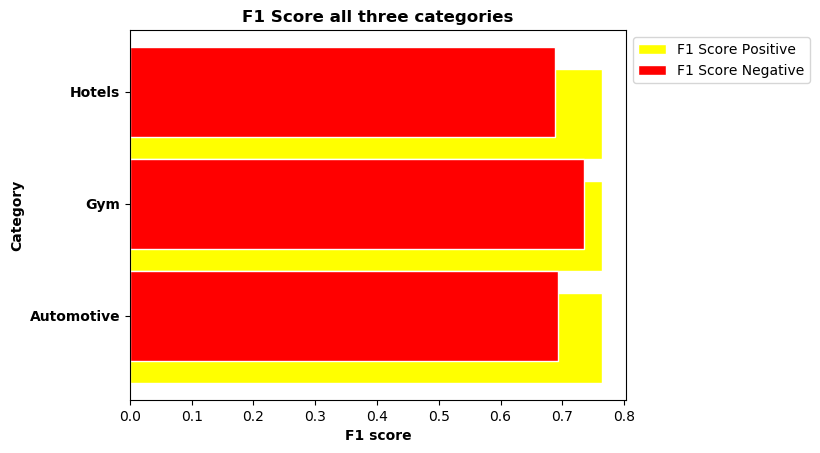

In [396]:
plt.figure()
F1_pos = [category1f1_pos,category3f1_pos,category3f1_pos]
F1_neg = [category1f1_neg,category2f1_neg,category3f1_neg]
barWidth = 0.2
pos1=np.arange(len(F1_pos))
pos2 = [x + barWidth for x in pos1]
plt.barh(pos1, F1_pos, color='yellow', edgecolor='white', label='var1')
plt.barh(pos2, F1_neg, color='red', edgecolor='white', label='var2')
 # labels read top-to-bottom
plt.title("F1 Score all three categories", fontweight='bold')
plt.xlabel('F1 score',fontweight='bold')
plt.ylabel('Category',fontweight='bold')
plt.yticks([r + barWidth for r in range(len(F1_pos))], ['Automotive','Gym','Hotels'],fontweight='bold')
plt.legend(["F1 Score Positive","F1 Score Negative"], bbox_to_anchor=(1, 1))
plt.show()

The disparity in the measurements is seen as unbalanced data for all three groups. Where positives were more than negative feedback. Since positive reviews were more frequent and properly expected, the F1-Score for positive class label increased. Negative F1-Score should give you a better understanding of how good the model can be at predicting.

For all 3 categories, the positive F1 level is nearly the same. Although the F1-Score is somewhat different for the minority class category, this is a negative class rating. The class negative scores in the Hotel category are the highest foreseen and the least foreseen in the Automotive category.

## Task 3: Evaluating the performance of each of the three classification models when applied to data from the other two selected categories

The biggest issue we see when data is vectorized and we try to fit one category but the model is trained with another is that the number of features could be different and errors could be thrown.<br>
Vertorizing generates only a number of features from the data supplied to it as an input.<br>
Basically, the common approaches followed include the reduction of the dimensionality of datasets to identical features, features in test data but no training datesets can be excluded or the same vetorizer used on training set could be used on test set.<br>

Approach i have followed is to use the same vetorizer used on training set on test set

### Classification Model on Category1(Automative), Performance evaluation on Category2(Gym) and Category3(Hotels)

Category1-Automotive vectorizer is used to convert Category2-Gym and Category3-Hotels data in such a way that they all have the same form.

In [306]:
automotiveGymX=vectorizerCategory1.transform(reviewCategory2)
automotiveHotelsX=vectorizerCategory1.transform(reviewCategory3)

#### Creating Model:
Creating the Naive Bayes model and Category1-Automotive training data is fitted

In [307]:
nbCategory1 = GaussianNB()
nbCategory1.fit(category1_train_x.toarray(), category1_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)


#### Predicting:
Model generated in the above step is used for predicting test created using Category1-Automotive vectorizer

In [308]:
automotiveGymPrediction = nbCategory1.predict(automotiveGymX.toarray()) 
automotiveHotelsPrediction = nbCategory1.predict(automotiveHotelsX.toarray())

#### Testing:
The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [309]:
print(confusion_matrix(automotiveGymPrediction, targetTypeCategory2,labels=['Negative','Positive']))

[[493 439]
 [208 860]]


In [310]:
print(confusion_matrix(automotiveHotelsPrediction, targetTypeCategory3,labels=['Negative','Positive']))

[[533 262]
 [291 914]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information displayed below are<br> Accuracy, Recall, F1 score and Support.

In [311]:
print(classification_report(automotiveGymPrediction, targetTypeCategory2, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.70      0.53      0.60       932
    Positive       0.66      0.81      0.73      1068

    accuracy                           0.68      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.68      0.67      2000



In [312]:
print(classification_report(automotiveHotelsPrediction, targetTypeCategory3, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.65      0.67      0.66       795
    Positive       0.78      0.76      0.77      1205

    accuracy                           0.72      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.73      0.72      0.72      2000



The F1 score could be used to compare results for each class[Positive Or Negative], as previously stated, with the imbalanced data. This data is expressed graphically by F1 scores with other categories.

In [313]:
automotiveGymF1_pos = f1_score(automotiveGymPrediction, targetTypeCategory2, pos_label='Positive')
automotiveGymF1_neg = f1_score(automotiveGymPrediction, targetTypeCategory2, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against GYM category = %.2f" % automotiveGymF1_pos )
print("F1 score for NEGATIVE review evaluated against GYM category = %.2f" % automotiveGymF1_neg )

F1 score for POSITIVE review evaluated against GYM category = 0.73
F1 score for NEGATIVE review evaluated against GYM category = 0.60


In [314]:
automotiveHotelsF1_pos = f1_score(automotiveHotelsPrediction, targetTypeCategory3, pos_label='Positive')
automotiveHotelsF1_neg = f1_score(automotiveHotelsPrediction, targetTypeCategory3, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against HOTELs category = %.2f" % automotiveHotelsF1_pos )
print("F1 score for NEGATIVE review evaluated against HOTELs category = %.2f" % automotiveHotelsF1_neg )

F1 score for POSITIVE review evaluated against HOTELs category = 0.77
F1 score for NEGATIVE review evaluated against HOTELs category = 0.66


#### F1 Scores for Positive and Negative Class Labels when data used for training is Category1-Automotive and evaluated on data from  Category2-Gym and Category3-Hotels 

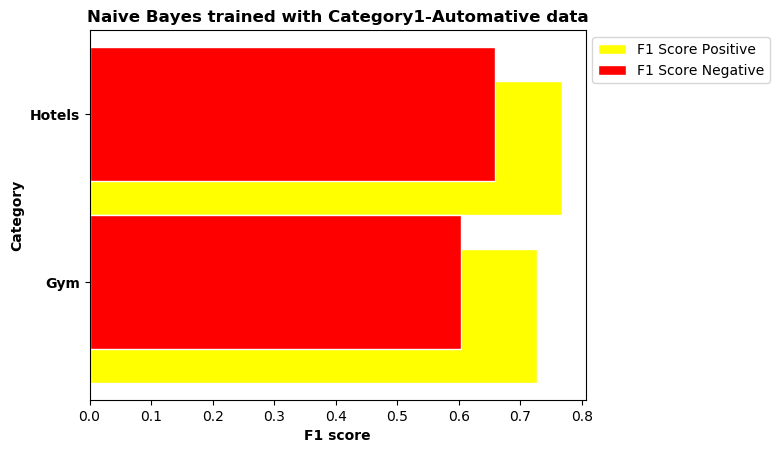

In [315]:
plt.figure()
F1_pos = [automotiveGymF1_pos,automotiveHotelsF1_pos]
F1_neg = [automotiveGymF1_neg,automotiveHotelsF1_neg]
barWidth = 0.2
pos1=np.arange(len(F1_pos))
pos2 = [x + barWidth for x in pos1]
plt.barh(pos1, F1_pos, color='yellow', edgecolor='white', label='var1')
plt.barh(pos2, F1_neg, color='red', edgecolor='white', label='var2')
 # labels read top-to-bottom
plt.title("Naive Bayes trained with Category1-Automative data", fontweight='bold')
plt.xlabel('F1 score',fontweight='bold')
plt.ylabel('Category',fontweight='bold')
plt.yticks([r + barWidth for r in range(len(F1_pos))], ['Gym','Hotels'],fontweight='bold')
plt.legend(["F1 Score Positive","F1 Score Negative"], bbox_to_anchor=(1, 1))
plt.show()

The measurement variations are known to be unequaled, with almost the same positive degree of F1. While for the minority class community, the F1 score is slightly different, it is a negative class cause could be fewer negatve records

### Classification Model on Category2(Gym), Performance evaluation on Category1(Automative) and Category3(Hotels)

Category2-Gym vectorizer is used to convert Category1-Automotive and Category3-Hotels data in such a way that they all have the same form.

In [326]:
gymAutomotiveX=vectorizerCategory2.transform(reviewCategory1)
gymHotelsX=vectorizerCategory2.transform(reviewCategory3)

#### Creating Model:
Creating the Naive Bayes model and Category2-Gym training data is fitted

In [327]:
nbCategory2 = GaussianNB()
nbCategory2.fit(category2_train_x.toarray(), category2_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Predicting:
Model generated in the above step is used for predicting test created using Category2-Gym vectorizer

In [328]:
gymAutomotivePrediction = nbCategory2.predict(gymAutomotiveX.toarray()) 
gymHotelsPrediction = nbCategory2.predict(gymHotelsX.toarray())

#### Testing:
The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [329]:
print(confusion_matrix(gymAutomotivePrediction, targetTypeCategory1,labels=['Negative','Positive']))

[[612 661]
 [176 551]]


In [330]:
print(confusion_matrix(gymHotelsPrediction, targetTypeCategory3,labels=['Negative','Positive']))

[[525 437]
 [299 739]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information displayed below are<br> Accuracy, Recall, F1 score and Support.

In [331]:
print(classification_report(gymAutomotivePrediction, targetTypeCategory1, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.78      0.48      0.59      1273
    Positive       0.45      0.76      0.57       727

    accuracy                           0.58      2000
   macro avg       0.62      0.62      0.58      2000
weighted avg       0.66      0.58      0.58      2000



In [332]:
print(classification_report(gymHotelsPrediction, targetTypeCategory3, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.64      0.55      0.59       962
    Positive       0.63      0.71      0.67      1038

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



The F1 score could be used to compare results for each class[Positive Or Negative], as previously stated, with the imbalanced data. This data is expressed graphically by F1 scores with other categories.

In [333]:
gymAutomotiveF1_pos = f1_score(gymAutomotivePrediction, targetTypeCategory1, pos_label='Positive')
gymAutomotiveF1_neg = f1_score(gymAutomotivePrediction, targetTypeCategory1, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against AUTOMOTIVE category = %.2f" % gymAutomotiveF1_pos )
print("F1 score for NEGATIVE review evaluated against AUTOMOTIVE category = %.2f" % gymAutomotiveF1_neg )

F1 score for POSITIVE review evaluated against AUTOMOTIVE category = 0.57
F1 score for NEGATIVE review evaluated against AUTOMOTIVE category = 0.59


In [334]:
gymHotelsF1_pos = f1_score(gymHotelsPrediction, targetTypeCategory3, pos_label='Positive')
gymHotelsF1_neg = f1_score(gymHotelsPrediction, targetTypeCategory3, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against HOTELS category = %.2f" % gymHotelsF1_pos )
print("F1 score for NEGATIVE review evaluated against HOTELS category = %.2f" % gymHotelsF1_neg )

F1 score for POSITIVE review evaluated against HOTELS category = 0.67
F1 score for NEGATIVE review evaluated against HOTELS category = 0.59


#### F1 Scores for Positive and Negative Class Labels when data used for training is Category2-Gym and evaluated on data from  Category1-Automotive and Category3-Hotels 

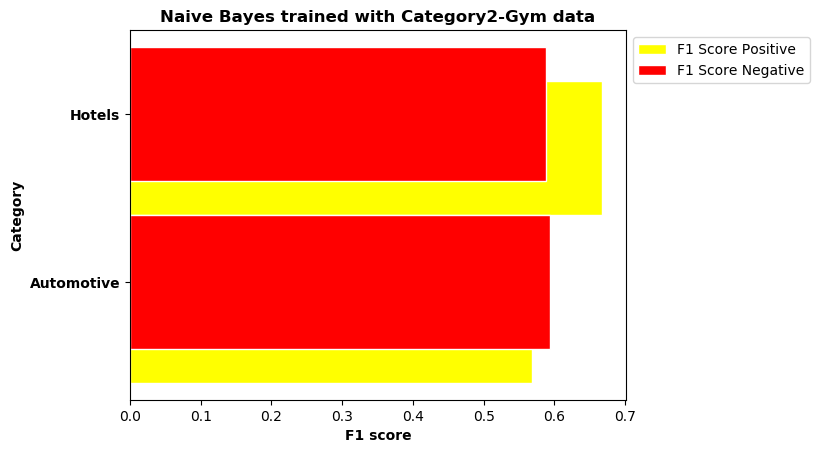

In [394]:
plt.figure()
F1_pos = [gymAutomotiveF1_pos,gymHotelsF1_pos]
F1_neg = [gymAutomotiveF1_neg,gymHotelsF1_neg]
barWidth = 0.2
pos1=np.arange(len(F1_pos))
pos2 = [x + barWidth for x in pos1]
plt.barh(pos1, F1_pos, color='yellow', edgecolor='white', label='var1')
plt.barh(pos2, F1_neg, color='red', edgecolor='white', label='var2')
 # labels read top-to-bottom
plt.title("Naive Bayes trained with Category2-Gym data", fontweight='bold')
plt.xlabel('F1 score',fontweight='bold')
plt.ylabel('Category',fontweight='bold')
plt.yticks([r + barWidth for r in range(len(F1_pos))], ['Automotive','Hotels'],fontweight='bold')
plt.legend(["F1 Score Positive","F1 Score Negative"], bbox_to_anchor=(1, 1))
plt.show()

The measurement variations are known to be unequaled, there is significant difference in both positive and negative classes. Classes classified as positive is less than classes calssifed as negative in case of Category3-Automotive. This could possible be because of words used in the reviews of these categories(Autmotive, Gym) are very different.

### Classification Model on Category3(Hotels), Performance evaluation on Category1(Automative) and Category2(Gym)

Category3-Hotels vectorizer is used to convert Category1-Automotive and Category2-Gym data in such a way that they all have the same form.

In [336]:
hotelsAutomotiveX=vectorizerCategory3.transform(reviewCategory1)
hotelsGymX=vectorizerCategory3.transform(reviewCategory2)

#### Creating Model:
Creating the Naive Bayes model and Category3-Hotels training data is fitted

In [337]:
nbCategory3 = GaussianNB()
nbCategory3.fit(category3_train_x.toarray(), category3_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Predicting:
Model generated in the above step is used for predicting test created using Category3-Hotels vectorizer

In [338]:
hotelsAutomotivePrediction = nbCategory3.predict(hotelsAutomotiveX.toarray()) 
hotelsGymPrediction = nbCategory3.predict(hotelsGymX.toarray())

#### Testing:
The easiest way to look if the model just correctly predicted the majority class and not the minority class is by seeing the confusion matrix. We will find out if the assumption for this is incorrect. From the matrix we can infer that in most cases the model has done significant work predicting classes correctly

In [339]:
print(confusion_matrix(hotelsAutomotivePrediction, targetTypeCategory1,labels=['Negative','Positive']))

[[655 645]
 [133 567]]


In [340]:
print(confusion_matrix(hotelsGymPrediction, targetTypeCategory2,labels=['Negative','Positive']))

[[498 415]
 [203 884]]


We can see that all the criteria for assessment are summarized using the classification_report function and the information displayed below are<br> Accuracy, Recall, F1 score and Support.


In [341]:
print(classification_report(hotelsAutomotivePrediction, targetTypeCategory1, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.83      0.50      0.63      1300
    Positive       0.47      0.81      0.59       700

    accuracy                           0.61      2000
   macro avg       0.65      0.66      0.61      2000
weighted avg       0.70      0.61      0.62      2000



In [342]:
print(classification_report(hotelsGymPrediction, targetTypeCategory2, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.71      0.55      0.62       913
    Positive       0.68      0.81      0.74      1087

    accuracy                           0.69      2000
   macro avg       0.70      0.68      0.68      2000
weighted avg       0.69      0.69      0.68      2000



The F1 score could be used to compare results for each class[Positive Or Negative], as previously stated, with the imbalanced data. This data is expressed graphically by F1 scores with other categories.

In [343]:
hotelsAutomotiveF1_pos = f1_score(hotelsAutomotivePrediction, targetTypeCategory1, pos_label='Positive')
hotelsAutomotiveF1_neg = f1_score(hotelsAutomotivePrediction, targetTypeCategory1, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against AUTOMOTIVE category = %.2f" % hotelsAutomotiveF1_pos )
print("F1 score for NEGATIVE review evaluated against AUTOMOTIVE category = %.2f" % hotelsAutomotiveF1_neg )

F1 score for POSITIVE review evaluated against AUTOMOTIVE category = 0.59
F1 score for NEGATIVE review evaluated against AUTOMOTIVE category = 0.63


In [344]:
hotelsGymF1_pos = f1_score(hotelsGymPrediction, targetTypeCategory2, pos_label='Positive')
hotelsGymF1_neg = f1_score(hotelsGymPrediction, targetTypeCategory2, pos_label='Negative')
print("F1 score for POSITIVE review evaluated against GYM category = %.2f" % hotelsGymF1_pos )
print("F1 score for NEGATIVE review evaluated against GYM category = %.2f" % hotelsGymF1_neg )

F1 score for POSITIVE review evaluated against GYM category = 0.74
F1 score for NEGATIVE review evaluated against GYM category = 0.62


#### F1 Scores for Positive and Negative Class Labels when data used for training is Category3-Hotels and evaluated on data from  Category1-Automotive and Category2-Gym 

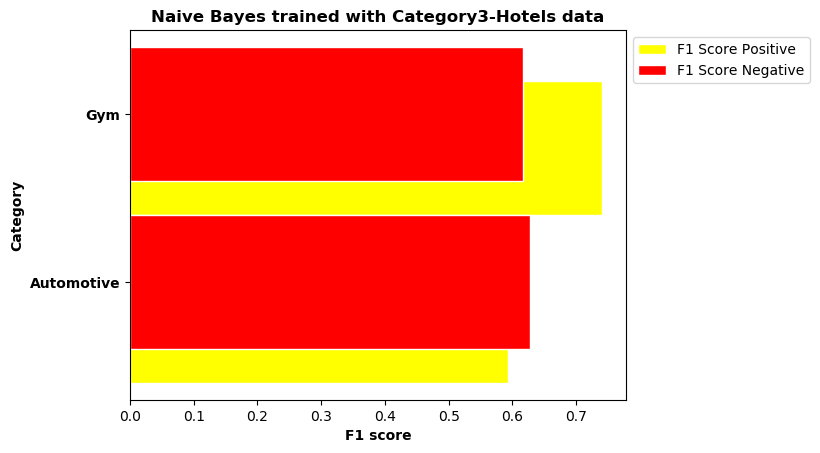

In [395]:
plt.figure()
F1_pos = [hotelsAutomotiveF1_pos,hotelsGymF1_pos]
F1_neg = [hotelsAutomotiveF1_neg,hotelsGymF1_neg]
barWidth = 0.2
pos1=np.arange(len(F1_pos))
pos2 = [x + barWidth for x in pos1]
plt.barh(pos1, F1_pos, color='yellow', edgecolor='white', label='var1')
plt.barh(pos2, F1_neg, color='red', edgecolor='white', label='var2')
 # labels read top-to-bottom
plt.title("Naive Bayes trained with Category3-Hotels data", fontweight='bold')
plt.xlabel('F1 score',fontweight='bold')
plt.ylabel('Category',fontweight='bold')
plt.yticks([r + barWidth for r in range(len(F1_pos))], ['Automotive','Gym'],fontweight='bold')
plt.legend(["F1 Score Positive","F1 Score Negative"], bbox_to_anchor=(1, 1))
plt.show()

The measurement variations are known to be unequaled, with almost the same negative degree of F1. While for the majority class community, the F1 score is slightly different, it is a positive class.Classes classified as positive is less than classes calssifed as negative in case of Category3-Automotive. This could possible be because of words used in the reviews of these categories(Automotive, Hotels) are very different.

### Conclusion

In Task 2, the F1 score for positive class markings is almost the same when the same class data was used for test set and training set, but for negative class marks, the explanation may be that data contained fewer records, of which the class markings were negative. In addition, the accuracy of the classification report is almost identical<br><br>

In Task 3, where the training set consists of one category while the test set consists of multiple categories we see variation in the F1 ratings, the potential reason may be that reviews are independent for each category and category specific terms vary in the classification of the review as positive or negative. This may also have contributed to a decline in accuracy. One particular observation is the models which are  trained from category2-Gym and category3-Hotels decreased prediction of Cateogory1-Automotive and the same is not true in the contrary.